In [111]:
import os
import numpy as np
import scipy as sp
import librosa as lib
import matplotlib.pyplot as plt
import sounddevice as sd
import pywt
import soundfile

In [112]:
def PTM(P,k):
    Ptemp=10*(np.log10(np.power(10,0.1*(P[k-1]))+np.power(10,0.1*(P[k]))+np.power(10,0.1*(P[k+1]))))
    return Ptemp
def mask(pk,k):
    a=False
    Dk=[1,2,3,4,5,6]
    if(k<3 or k>250):
        return False
    else:
        if(k>2 and k<63):
            return ((pk[k]>pk[k+Dk[0]]) and (pk[k]>pk[k-Dk[0]])) and ((pk[k]>pk[k+Dk[1]]+7) and (pk[k]>pk[k-Dk[1]]+7))
        if(k>=63 and k<127):
            for i in range(2):
                temp=((pk[k]>pk[k+Dk[0]]) and (pk[k]>pk[k-Dk[0]])) and ((pk[k]>pk[k+Dk[i+1]]+7) and (pk[k]>pk[k-Dk[i+1]]+7))
                if(temp==True):
                    a=True
                    break
                if(temp==False):
                    continue    
            return a
        if(k>=127 and k<=250):
            for i in range(5):
                temp=((pk[k]>pk[k+Dk[0]]) and (pk[k]>pk[k-Dk[0]])) and ((pk[k]>pk[k+Dk[i+1]]+7) and (pk[k]>pk[k-Dk[i+1]]+7))
                if(temp==True):
                    a=True
                    break
                if(temp==False):
                    continue
            return a
def SF(Db,j,ptm):
    if(Db>=-3 and Db<-1):
        return 17*Db-0.4*ptm[j]+11
    if(Db>=-1 and Db<0):
        return (0.4*ptm[j]+6)*Db
    if(Db>=0 and Db<1):
        return -17*Db
    if(Db>=1 and Db<8):
        return (0.15*ptm[j]-17)*Db-0.15*ptm[j]
    else:
        return 0

In [113]:
def mid_rise(d,y,bits):
    k_max=int((2**bits)/2)
    n=np.linspace(0,k_max,k_max)
    y_q=np.array([])
    for i in range(len(y)):
        count=0
        start=0
        for k in range(len(n)):
            end=(k+1)*d
            if((start<=abs(y[i])) and ((abs(y[i]))<=(end))):
                if(y[i]>0):
                    y_q=np.append(y_q,(0.5+k)*d)
                    count=1
                elif(y[i]<0):
                    y_q=np.append(y_q,(-0.5-k)*d)
                    count=1
                elif(y[i]==0):
                    y_q=np.append(y_q,0)
                    count=1
            start=end
    return y_q
                
    return y_q
def interpolate(y,M):
    n=len(y)*M
    interp=np.array([0.]*n)
    for i in range(n):
        if(i%M==0):
            interp[i]=y[i//M]
    return interp

def decimate(sig, factor):
    out = []
    for i in range(sig.size):
        if i%factor == 0:
            out.append(sig[i])
    return np.asarray(out)

In [34]:
#ΣΥΝΑΡΤΗΣΗ ΑΝΑΛΥΣΙΣ ΠΛΑΙΣΙΟΥ ΓΙΑ ΥΠΟΛΟΓΙΣΜΟ ΣΥΝΟΛΙΚΟΥ ΚΑΤΩΦΛΙΟΥ ΚΑΛΥΨΗΣ#
def analysis_part_1(music,analysis_place):
    win=np.hanning(512)
    PN=90.302
    Pk=np.array([])
    for k in range(257):
        sum_w=0
        for i in range(512):
            sum_w=sum_w+music[i]*win[i]*np.exp(-1j*(2*np.pi*k*i/512))
        sum_w=10*np.log10(np.abs(sum_w)**2)
        Pk=np.append(Pk,sum_w+PN)
    mask_arr=np.array([],dtype='b')
    for i in range(257):
        mask_arr=np.append(mask_arr,mask(Pk,i))
    places_arr=np.array([])
    for i in range(257):
        if(mask_arr[i]==1):
            places_arr=np.append(places_arr,i)
    ptm=np.array([])
    for i in range(len(mask_arr)):
        if(mask_arr[i]==1):
            ptm=np.append(ptm,PTM(Pk,i))
        if(mask_arr[i]==0):
            ptm=np.append(ptm,0)
    pnm=np.transpose(np.load("dsp21_lab3_material/P_NM.npy"))
    pnm_c=np.transpose(np.load("dsp21_lab3_material/P_NMc.npy"))
    ptm_c=np.transpose(np.load("dsp21_lab3_material/P_NMc.npy"))
    pnm=pnm_c[analysis_place]
    ptm=ptm_c[analysis_place]
    for i in range(len(ptm)):
        if(i<3 or i>250):
            ptm[i]=0
            pnm[i]=0
    ttm_total={}
    for i in range(256):
        if(ptm[i]>0):
            ttm=np.array([0]*256)
            L1=bf[i]-3
            L2=bf[i]+8
            for j in range(256):
                if(bf[j]>L1 and bf[j]<L2):
                    Db=bf[j]-bf[i]
                    ttm[j]=ptm[i]-0.275*bf[i]+SF(Db,i,ptm)-6.025
            ttm_total["Mask_Place_{}".format(i)]=ttm
    tnm_total={}
    for i in range(256):
        if(pnm[i]>0):
            tnm=np.array([0]*256)
            L1=bf[i]-3
            L2=bf[i]+8
            for j in range(256):
                if(bf[j]>L1 and bf[j]<L2):
                    Db=bf[j]-bf[i]
                    tnm[j]=pnm[i]-0.175*bf[i]+SF(Db,i,pnm)-2.025
            tnm_total["Mask_Place_{}".format(i)]=tnm
    tg=np.array([0.]*256)
    for i in range(256):
        tg[i]=tg[i]+np.power(10,0.1*tq[i])
        for j in ttm_total:
            tg[i]=tg[i]+np.power(10,0.1*ttm_total[j][i])
        for j in tnm_total:
            tg[i]=tg[i]+np.power(10,0.1*tnm_total[j][i])
    tg=10*np.log10(tg)
    return tg

In [41]:
#ΣΥΝΑΡΤΗΣΗ ΑΝΑΛΥΣΙΣ ΠΛΑΙΣΙΟΥ ΔΕΥΤΕΡΟ ΜΕΡΟΣ#
def analysis_part_2(tg,music,quant_type):
    filters={}
    synths={}
    n=np.linspace(0,64,64)
    for i in range(32):
        h=np.array([])
        g=np.array([])
        for j in n:
            h1=np.sin((int(j)+0.5)*np.pi/64)*0.25*np.cos(((2*int(j)+32+1)*(2*i+1)*np.pi)/(4*32))
            g1=np.sin((64-1-int(j)+0.5)*np.pi/64)*0.25*np.cos(((2*(64-1-int(j))+32+1)*(2*i+1)*np.pi)/(4*32))
            h=np.append(h,h1)
            g=np.append(g,g1)
        filters["k_{}".format(i)]=h
        synths["k_{}".format(i)]=g
    filtered={}
    for i in range(32):
        filtered["k_{}".format(i)]=np.convolve(filters["k_{}".format(i)],music,mode="full")
    decimated={}
    for i in range(32):
        decimated["k_{}".format(i)]=decimate(filtered["k_{}".format(i)],32)

        
    R=2**16
    B={}
    step={}
    lim=44100*np.pi/(2*32)
    for k in range(1,33):
        i1=0
        i2=0
        count=0
        fk=(2*k-1)*44100*np.pi/(2*32)
        for i in range(256):
            fi=i*2*np.pi*44100/512 
            if(fi>=(fk-lim) and fi<=(fk+lim)):
                if(count==0):
                    i1=i
                    count=count+1    
                i2=i
        B_temp=np.log2(R/np.min(tg[i1:i2]))-1
        B["k_{}".format(k-1)]=B_temp
    



    

    quantized={}
    if(quant_type==1):
        for i in decimated:
            if(B[i]>int(B[i])):
                B[i]=int(B[i])+1
            step["{}".format(i)]=(2*np.max(abs(decimated[i])))/(2**B[i])
            quantized["{}".format(i)]=mid_rise(step[i],decimated[i],B[i])
    else:
        for i in decimated:
            B[i]=8
            step["{}".format(i)]=(2*np.max(abs(decimated[i])))/(2**B[i])
            quantized["{}".format(i)]=mid_rise(step[i],decimated[i],B[i])

        
    synthesis={}
    for i in quantized:
        synthesis["{}".format(i)]=np.convolve(interpolate(quantized[i],32),synths[i]) 
        
    count=0
    s_n=np.array([0.]*639)
    for i in synthesis:
        s_n=s_n+synthesis[i]
    return s_n

In [42]:
#Absolute Threshold of Hearing#
fs=44100
NFFT=512
f = np.linspace(1*fs//NFFT, (NFFT//2)*fs//NFFT, NFFT//2)
tq=3.64*np.power((f/1000),-0.8)-6.5*np.exp(-0.6*(np.power((f/1000)-3.3,2)))+0.001*np.power((f/1000),4)
tq[0]=40

In [43]:
bf=13*np.arctan(0.00076*f)+3.5*np.arctan(np.power((f/7500),2))
print(len(bf))

256


In [44]:
music,sr=lib.load("dsp21_lab3_material/music.wav",44100)
max_music=np.max(np.abs(music))
music=music/max_music

In [45]:
s_n_total_1=np.array([0.]*len(music))
j=0
count=0
for i in range(1178):
    tg=analysis_part_1(music[i*512:(i+1)*512],i)
    s_n=analysis_part_2(tg,music[i*512:(i+1)*512],1)
    for i in range(639):
        s_n_total_1[j]=s_n[i]+s_n_total_1[j]
        j=j+1
    j=512*(count+1)
    count=count+1
print("DONE")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [48]:
s_n_total_2=np.array([0.]*len(music))
j=0
count=0
for i in range(1178):
    tg=analysis_part_1(music[i*512:(i+1)*512],i)
    s_n=analysis_part_2(tg,music[i*512:(i+1)*512],0)
    for i in range(607):
        s_n_total_2[j]=s_n[i]+s_n_total_2[j]
        j=j+1
    j=512*(count+1)
    count=count+1
print("DONE")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

[1.89605890e-05 5.15220713e-05 8.61100995e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-0.03943675 -0.0217835  -0.00908975 ...  0.29932386  0.2934554
  0.28814507]


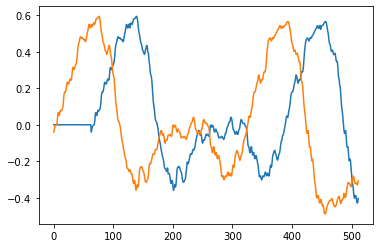

In [114]:
sd.play(s_n_total_1,44100)
plt.plot(s_n_total_1[0:512])
print(s_n_total_1)
plt.plot(music[0:512])
print(music)

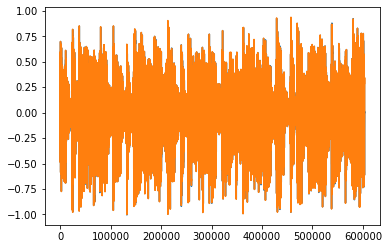

In [51]:
b=s_n_total_2
sd.play(b,44100)
soundfile.write("song_1.wav",b,44100)
soundfile.write("song_2.wav",s_n_total_2,44100)
plt.plot(b)
plt.plot(music)

In [76]:
MSE_ad=0
MSE_arr_ad=np.array([0.]*len(music))
for i in range(len(s_n_total_1)):
    a=(music[i]-s_n_total_1[i])**2
    MSE_arr_ad[i]=a
MSE_8_bit=0
MSE_arr_8_bit=np.array([0.]*len(music))
for i in range(len(s_n_total_2)):
    a=(music[i]-s_n_total_2[i])**2
    MSE_arr_8_bit[i]=a

In [77]:
MSE_ad=np.sum(MSE_arr_ad)/len(music)
MSE_8_bit=np.sum(MSE_arr_8_bit)/len(music)

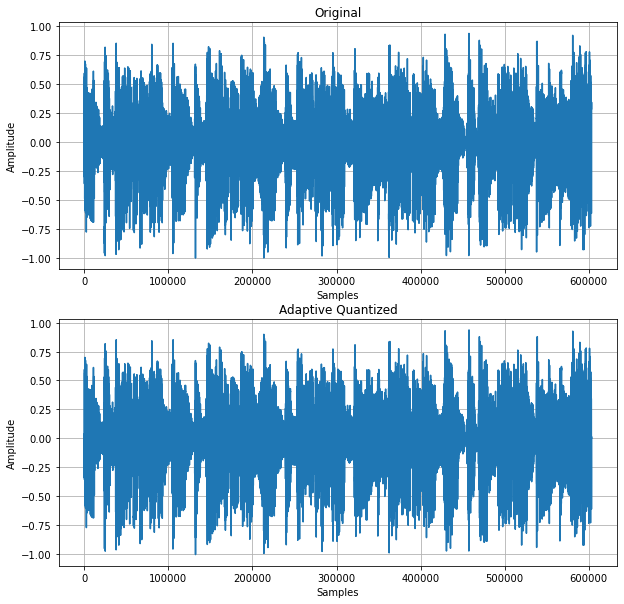

In [101]:
fig, axs = plt.subplots(2,figsize=(10,10))
axs[0].set_title("Original")
axs[0].plot(music)
axs[0].grid()
axs[0].set_xlabel("Samples")
axs[0].set_ylabel("Amplitude")
axs[1].set_title("Adaptive Quantized")
axs[1].grid()
axs[1].set_xlabel("Samples")
axs[1].set_ylabel("Amplitude")
axs[1].plot(s_n_total_1)

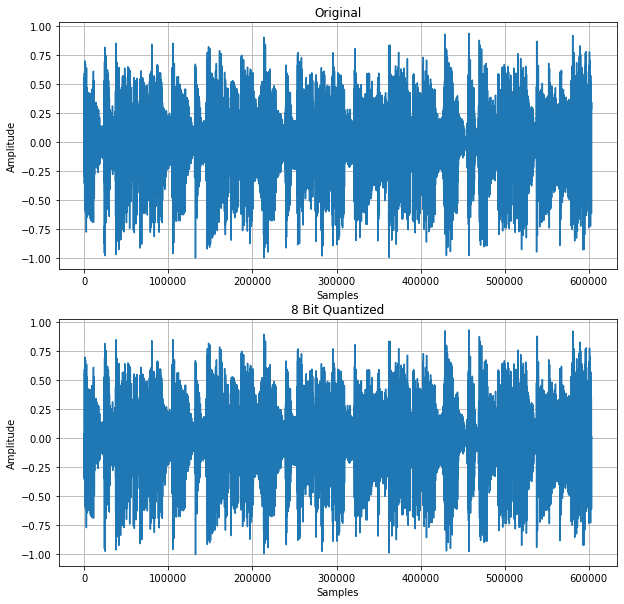

In [102]:
fig, axs = plt.subplots(2,figsize=(10,10))
axs[0].set_title("Original")
axs[0].plot(music)
axs[0].grid()
axs[0].set_xlabel("Samples")
axs[0].set_ylabel("Amplitude")
axs[1].set_title("8 Bit Quantized")
axs[1].grid()
axs[1].set_xlabel("Samples")
axs[1].set_ylabel("Amplitude")
axs[1].plot(s_n_total_2)

In [107]:
c=np.roll(s_n_total_1,-64)
d=np.roll(s_n_total_2,-64)

In [108]:
MSE_ad=0
MSE_arr_ad=np.array([0.]*len(music))
for i in range(len(c)):
    a=(music[i]-c[i])**2
    MSE_arr_ad[i]=a
MSE_ad=np.sum(MSE_arr_ad)/len(music)

MSE_8_bit=0
MSE_arr_8_bit=np.array([0.]*len(music))
for i in range(len(s_n_total_2)):
    a=(music[i]-d[i])**2
    MSE_arr_8_bit[i]=a
MSE_8_bit=np.sum(MSE_arr_8_bit)/len(music)

print(MSE_ad)
print(MSE_8_bit)


0.00035487550250893284
0.0003557365425929375


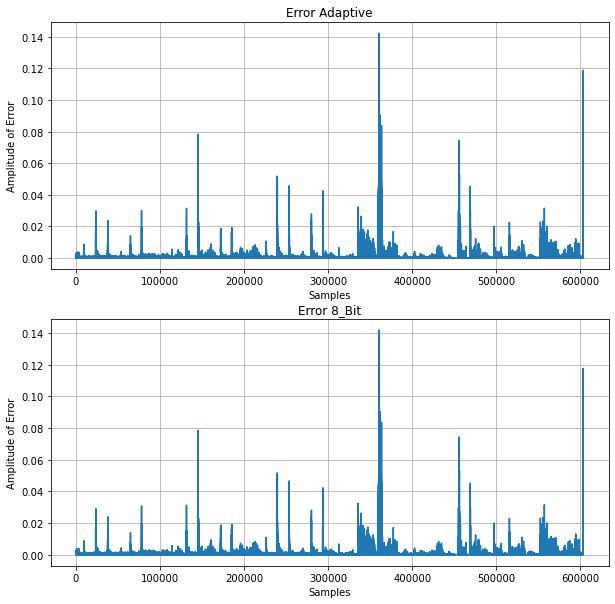

In [110]:
fig, axs = plt.subplots(2,figsize=(10,10))
axs[0].set_title("Error Adaptive")
axs[0].plot(MSE_arr_ad)
axs[0].grid()
axs[0].set_xlabel("Samples")
axs[0].set_ylabel("Amplitude of Error")
axs[1].set_title("Error 8_Bit")
axs[1].grid()
axs[1].set_xlabel("Samples")
axs[1].set_ylabel("Amplitude of Error")
axs[1].plot(MSE_arr_8_bit)